## 004 Model with Data Augmentation

In [5]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np
from keras.models import load_model

from pylab import rcParams
rcParams['figure.figsize'] = (8,6)

In [6]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../51c5ca37'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [7]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [19]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

#render.plot_image(x_train[0])
#print(y_train[122])

#render.plot_image(x_train[2])
#print(y_train[2])

#render.plot_image(x_train[8])
#print(y_train[8])


In [8]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [9]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [22]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_simple_v2_3class_dropout()
display(model.summary())

# parameters:
learning_rate = 1e-4

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
__________

None

In [23]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[3 3 1 3 1 1 3 3 3 1 3 1 3 3 3 3 2 3 3 2 3 1 3 3 3 2 1 3 3 2 3 3 3 1 3 3 1
 1 3 3 1 3 3 3 3 1 1 1 3 2 3 2 3 3 1 2 3 3 3 2 3 1 3 1 3 3 3 3 1 1 1 3 3 3
 1 3 1 1 3 3 1 2 3 2 3 1 3 3 2 3 3 3 2 3 3 2 3 3 1 3] [2 3 2 1 1 3 2 1 1 3 3 1 3 3 3 1 3 3 3 3 1 3 1 1 1 3 2 2 3 3 3 2 2 3 3 1 1
 1 1 3 3 3 2 1 3 2 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 3 3 3 3 2 3 2 3 1 2 2 1 3
 1 3 3 3 3 2 3 3 1 3 3 1 3 2 3 3 3 1 3 2 1 1 3 1 2 2] [2 2 3 1 1 1 2 2 2 2 2 2 2 3 1 1 3 1 2 1 3 3 2 3 2 3 3 2 2 3 3 1 3 3 3 3 3
 3 2 2 1 1 2 1 3 1 1 3 1 2 1 3 3 1 3 3 2 1 3 3 2 3 3 2 3 3 2 1 2 1 3 2 2 3
 1 1 1 2 2 1 2 3 3 1 3 1 2 3 3 2 1 3 2 1 1 1 2 1 3 2]


In [24]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

# parameters
epochs = 6
batch_size = 16

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer()])


#history = model.fit(x_train,y_train_oh, batch_size=batch_size,
#                              epochs = epochs,
#                              validation_data = (x_test,y_test_oh), shuffle=True,
#                              verbose = 1, callbacks=[cnn_models.annealer()])

Epoch 1/6
4159/4159 [==============================] - 156s 38ms/step - loss: 0.4651 - acc: 0.8321 - val_loss: 0.5492 - val_acc: 0.7585
Epoch 2/6
4159/4159 [==============================] - 155s 37ms/step - loss: 0.3333 - acc: 0.8703 - val_loss: 0.5728 - val_acc: 0.7017
Epoch 3/6
4159/4159 [==============================] - 155s 37ms/step - loss: 0.2837 - acc: 0.8898 - val_loss: 0.5309 - val_acc: 0.8381
Epoch 4/6
4159/4159 [==============================] - 156s 37ms/step - loss: 0.2481 - acc: 0.9024 - val_loss: 0.7518 - val_acc: 0.8182
Epoch 5/6
4159/4159 [==============================] - 156s 37ms/step - loss: 0.2309 - acc: 0.9098 - val_loss: 0.4500 - val_acc: 0.8381
Epoch 6/6
4159/4159 [==============================] - 155s 37ms/step - loss: 0.2152 - acc: 0.9163 - val_loss: 0.6298 - val_acc: 0.8381


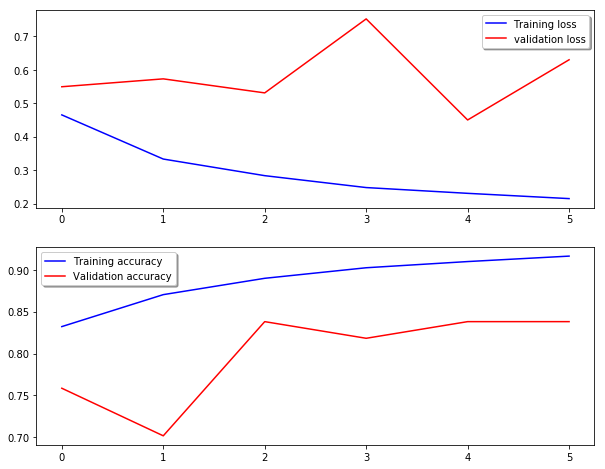

Precision (specificity): 81.370%
Recall (sensitivity): 64.508%
Accuracy: 66.355%
F1: 65.348%


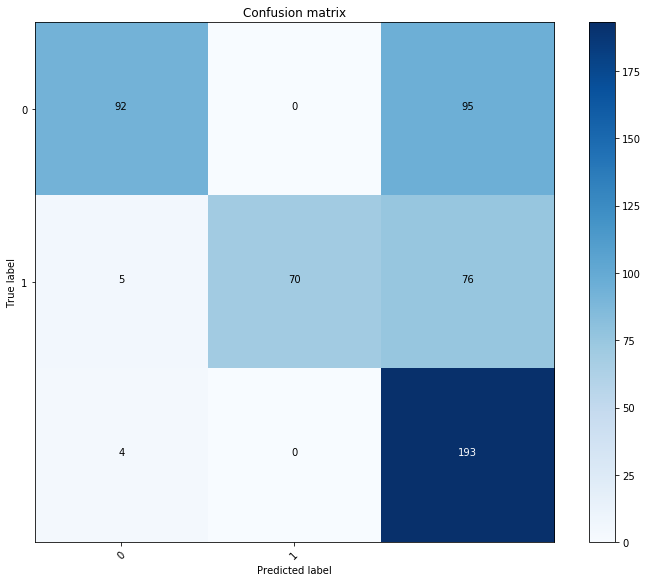

In [25]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [26]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

hgv-dffcce57 [0.13003214 0.34095335 0.52901447] 2
hgv-2cdb69f6 [5.5952271e-04 6.2037829e-02 9.3740255e-01] 1
hgv-99fc12a1 [0.7940872  0.20422477 0.00168805] 0
odi-897669a0 [9.9693769e-01 3.0525844e-03 9.7557077e-06] 0
hgv-2d4a6a46 [0.7613036  0.23608409 0.00261236] 0
odi-897669a0 [0.8685193  0.12898634 0.00249422] 1
mdi-5e3d3832 [1.1768581e-02 1.0354277e-04 9.8812795e-01] 2
hgv-8528141b [0.01207017 0.8566692  0.13126072] 1
mdi-df9a656f [2.3704565e-04 2.9582457e-06 9.9975997e-01] 2


In [27]:
model.save('model_004_dataaug2_adamopt_sp.h5')

In [11]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_3layer(3)
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = keras.optimizers.Adam(lr=learning_rate), loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       55424     
__________

None

In [12]:
## Now Let's do a run with data augmentation
reload(cnn_models)

# parameters
epochs = 12
batch_size = 32


history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(1)])

Train on 4159 samples, validate on 352 samples
Epoch 1/12
4159/4159 [==============================] - 14s 3ms/step - loss: 0.6931 - acc: 0.7771 - val_loss: 0.5354 - val_acc: 0.8239
Epoch 2/12
4159/4159 [==============================] - 12s 3ms/step - loss: 0.5453 - acc: 0.8201 - val_loss: 0.5307 - val_acc: 0.8267
Epoch 3/12
4159/4159 [==============================] - 12s 3ms/step - loss: 0.5258 - acc: 0.8259 - val_loss: 0.5758 - val_acc: 0.8267
Epoch 4/12
4159/4159 [==============================] - 12s 3ms/step - loss: 0.5069 - acc: 0.8283 - val_loss: 0.6592 - val_acc: 0.6392

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/12
4159/4159 [==============================] - 12s 3ms/step - loss: 0.4461 - acc: 0.8391 - val_loss: 0.5230 - val_acc: 0.8324
Epoch 6/12
4159/4159 [==============================] - 12s 3ms/step - loss: 0.3957 - acc: 0.8500 - val_loss: 0.4934 - val_acc: 0.8466
Epoch 7/12
4159/4159 [==============================] - 12s 3m

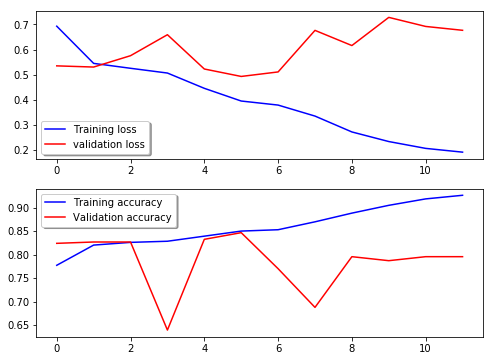

Precision (specificity): 79.440%
Recall (sensitivity): 61.378%
Accuracy: 63.738%
F1: 61.767%


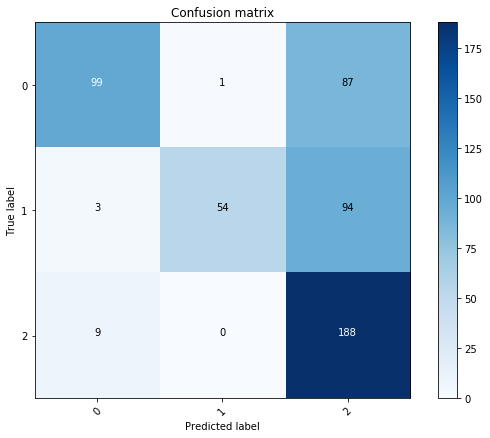

In [17]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=3)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [15]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

odi-819f9608 [0.03585939 0.01281645 0.95132405] 1
hgv-2cdb69f6 [0.02718879 0.40241712 0.5703943 ] 1
odi-a981441f [1.6909529e-03 2.1086882e-05 9.9828798e-01] 1
mdi-5e3d3832 [0.6301953  0.03637707 0.3334273 ] 0
mdi-461bdebc [0.11192723 0.00673621 0.88133675] 2
mdi-5e3d3832 [1.682091e-02 3.021934e-04 9.828769e-01] 2
mdi-9abd4637 [1.7227622e-02 6.6325010e-04 9.8210913e-01] 2
mdi-e3b0c312 [4.1252328e-03 2.4220778e-04 9.9563265e-01] 0
mdi-f3f9ede5 [0.57509834 0.00961436 0.4152874 ] 0


In [3]:
## FIXES::

model = load_model('model_004_dataaug2_adamopt_sp.h5')


Precision (specificity): 81.370%
Recall (sensitivity): 64.508%
Accuracy: 66.355%
F1: 65.348%


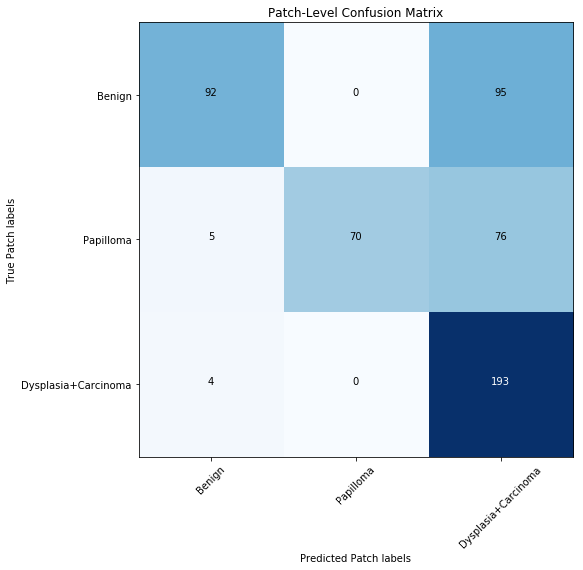

In [11]:
reload(analysis)
reload(render)
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8) # constant figure size

## PATCH LEVEL STATISTICS

# predictions
y_pred_oh = model.predict(x_val)
cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix_fix(cm, num_classes=3,
                                 labels=['Benign', 'Papilloma', 'Dysplasia+Carcinoma'], 
                                 stat_type='patch', save='exp5_patch_level_cm')

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [17]:
## ROI Level Statistics
reload(analysis)
reload(render)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))

preds, truths = analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))
#print(preds, truths)
cm = analysis.roi_cm(truths, preds, num_classes=3)
print(cm)
cm_norm = analysis.normalize_roi_cm(cm)

analysis.roi_stats_3class(cm_norm)

odi-819f9608 [0.08676697 0.0049939  0.9082392 ] 1
hgv-2cdb69f6 [0.03307865 0.5755221  0.39139917] 1
odi-a981441f [3.9094021e-03 3.3799377e-06 9.9608725e-01] 1
mdi-5e3d3832 [0.5232844 0.0029134 0.4738022] 0
mdi-461bdebc [6.9046028e-02 1.3400314e-04 9.3082011e-01] 2
mdi-5e3d3832 [7.016470e-02 7.924027e-04 9.290430e-01] 2
mdi-9abd4637 [2.1702604e-02 1.2761428e-05 9.7828454e-01] 2
mdi-e3b0c312 [1.7014319e-02 1.9170591e-06 9.8298377e-01] 0
mdi-f3f9ede5 [0.57984155 0.0012534  0.41890493] 0
[[1.12014031e+00 4.16871533e-03 1.87569082e+00]
 [1.23755015e-01 5.80519438e-01 2.29572558e+00]
 [1.60913333e-01 9.39167337e-04 2.83814764e+00]]
0.7973376993166287 0.9912909836065574 0.4048933590127684 0.3733666666666667 0.1935 0.946064868828961
Precision (specificity): 50.431%
Recall (sensitivity): 73.117%
Accuracy: 50.431%


In [19]:
## cleanup
import keras.backend as K
K.clear_session()